In [2]:
import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

print(common_variable.sections())
print(common_variable['database']['module_path'])
print(common_variable['database']['DB_BASE'])

import sys
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *

import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from parse import parse
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from glob import glob
from tqdm import tqdm_notebook

['database', 'mlflow', 'font']
/media/myungsungkwak/msdisk/docrv2_sroie/modules/database/
/media/myungsungkwak/msdisk/docrv2_data/DB/


In [3]:
def create_database(db_idx, db_name=None):
    path = common_variable['database']['DB_BASE']
    os.makedirs(path, exist_ok=True)

    name = db_name + "_%04d"%db_idx
    description = 'data db from train_task2 all coords images'
    datadb = create_data_db(path=path, name=name, description=description, data_class='DATA')
    print("... created db : ", name)
    return datadb

def update_database(datadb, imgs, coords, refname, db_start_idx):
    for idx, img in enumerate(imgs):
        chars = []
        chars.append(coords[idx][8])
        char_table = pd.DataFrame(coords[idx])
        char_table = char_table.T
        char_table.rename(columns={0:'x1', 1:'y1', 2:'x2', 3:'y2', 4:'x3',
                                   5:'y3', 6:'x4', 7:'y4', 8:'char'}, inplace=True)
        
        char_table.x1 = char_table.x1.astype(int)
        char_table.y1 = char_table.y1.astype(int)
        char_table.x2 = char_table.x2.astype(int)
        char_table.y2 = char_table.y2.astype(int)
        char_table.x3 = char_table.x3.astype(int)
        char_table.y3 = char_table.y3.astype(int)
        char_table.x4 = char_table.x4.astype(int)
        char_table.y4 = char_table.y4.astype(int)
        
        update_data(datadb, index=db_start_idx+idx, label='task12', image=img, text=chars[0], ref=refname)

def get_coords_from_image(txt_file):
    lps = []

    try:
        with open(txt_file, 'r') as f:
            coords_data = f.read().split('\n')
            for ii in range(len(coords_data)):
                if len(coords_data[ii]) > 0:
                    ps = parse('{},{},{},{},{},{},{},{},{}', coords_data[ii])
                    ps = list(ps)
                    ps[:-1] = list(map(int, ps[:-1]))
                    lps.append(ps)
    except:
        with open(txt_file, 'r', encoding='ISO-8859-1') as f:
            coords_data = f.read().split('\n')
            for ii in range(len(coords_data)):
                if len(coords_data[ii]) > 0:
                    ps = parse('{},{},{},{},{},{},{},{},{}', coords_data[ii])
                    ps = list(ps)
                    ps[:-1] = list(map(int, ps[:-1]))
                    lps.append(ps)
    return lps

In [3]:
"""
method 1 - no padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords(img_path, coords, num_images=1):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]
    
    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords)) 
    transpose_y1_coords = list(map(int, transpose_y1_coords))
    
    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords)) 
    transpose_y2_coords = list(map(int, transpose_y2_coords))    
    
    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords)) 
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords)) 
    transpose_y4_coords = list(map(int, transpose_y4_coords))
    
    transpose_chars = np.transpose(coords)[8]
    
    sample_list = []
    coords_list = []
    for idx in range(num_images):
        base_idx = idx

        new_x1 = transpose_x1_coords[base_idx]
        new_y1 = transpose_y1_coords[base_idx]

        new_x2 = transpose_x2_coords[base_idx]
        new_y2 = transpose_y2_coords[base_idx]

        new_x3 = transpose_x3_coords[base_idx]
        new_y3 = transpose_y3_coords[base_idx]

        new_x4 = transpose_x4_coords[base_idx]
        new_y4 = transpose_y4_coords[base_idx]
    
        crop_img = img.crop((new_x1,
                             new_y1,
                             new_x3,
                             new_y3))
        sample_list.append(crop_img)
        coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                           transpose_chars[base_idx]])

    return sample_list, coords_list

In [68]:
"""
method 2 - random size padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords_pad_random(img_path, coords, num_images=1):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]

    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords))
    transpose_y1_coords = list(map(int, transpose_y1_coords))

    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords))
    transpose_y2_coords = list(map(int, transpose_y2_coords))

    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords))
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords))
    transpose_y4_coords = list(map(int, transpose_y4_coords))

    transpose_chars = np.transpose(coords)[8]
    
    sample_list = []
    coords_list = []
    
    img_cnt = 0

    for _ in range(np.random.randint(5, 10)):
        # [-4  5  9  3] --> left right up bottom
        # num_images --> coords imags
        for idx in range(num_images):
            # pdd = np.random.randint(-5,10,4)
            pdd = np.random.randint(-5,5,4)
            base_idx = idx
            while True:
                if (transpose_x3_coords[base_idx] - transpose_x1_coords[base_idx] <= 20) or (transpose_y3_coords[base_idx] - transpose_x1_coords[base_idx]<=20):
                    new_x1 = transpose_x1_coords[base_idx]
                    new_y1 = transpose_y1_coords[base_idx]
                    new_x2 = transpose_x2_coords[base_idx]
                    new_y2 = transpose_y2_coords[base_idx]
                    new_x3 = transpose_x3_coords[base_idx]
                    new_y3 = transpose_y3_coords[base_idx]
                    new_x4 = transpose_x4_coords[base_idx]
                    new_y4 = transpose_y4_coords[base_idx]
                    break
                else:
                    new_x1 = transpose_x1_coords[base_idx] - pdd[0] # pad left
                    new_y1 = transpose_y1_coords[base_idx] - pdd[2] # pad up

                    new_x3 = transpose_x3_coords[base_idx] + pdd[1] # pad right
                    new_y3 = transpose_y3_coords[base_idx] + pdd[3] # pad bottom

                    new_x2 = new_x3
                    new_y2 = new_y1

                    new_x4 = new_x1
                    new_y4 = new_y3

                    if (new_x1 < 0) or (new_x4 < 0) or (new_x2 > o_width) or (new_x3 > o_width):
                        print("[problem] x coords")
                        pdd = np.random.randint(-5,10,4)
                        continue
                    if (new_y1 < 0) or (new_y2 < 0) or (new_y3 > o_height) or (new_y3 > o_height):
                        print("[problem] y coords")
                        pdd = np.random.randint(-5,10,4)
                        continue
                    break

            crop_img = img.crop((new_x1, new_y1, new_x3, new_y3))
            if (crop_img.size[0]) > 0 and (crop_img.size[1] > 0):
                sample_list.append(crop_img)
                coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                                    transpose_chars[base_idx]])

                img_cnt = img_cnt + 1

    return sample_list, coords_list, img_cnt

In [6]:
"""
method 3 - fixed size padding
crop images followed as original coordiantes
"""
def get_crop_image_by_coords_pad(img_path, coords, num_images=1, pad_max=5):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]

    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords))
    transpose_y1_coords = list(map(int, transpose_y1_coords))

    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords))
    transpose_y2_coords = list(map(int, transpose_y2_coords))

    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords))
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords))
    transpose_y4_coords = list(map(int, transpose_y4_coords))

    transpose_chars = np.transpose(coords)[8]
    
    """
    pad_type
    1) left ←
    2) right →
    3) up ↑
    4) bottom ↓
    5) all ←, →, ↑, ↓
    """
    # 1~5
    # p_size = np.random.randint(1, pad_max)
    p_size = pad_max # only 5 pix
    #pad_type = ["left", "right", "up", "bottom", "all"]
    pad_type = ["all"]

    sample_list = []
    coords_list = []
    
    for pad_idx in range(len(pad_type)):
        for idx in range(num_images):
            base_idx = idx

            new_x1 = transpose_x1_coords[base_idx]
            new_y1 = transpose_y1_coords[base_idx]

            new_x2 = transpose_x2_coords[base_idx]
            new_y2 = transpose_y2_coords[base_idx]

            new_x3 = transpose_x3_coords[base_idx]
            new_y3 = transpose_y3_coords[base_idx]

            new_x4 = transpose_x4_coords[base_idx]
            new_y4 = transpose_y4_coords[base_idx]
            
            if pad_type[pad_idx] == "left":
                new_x1 = new_x1 - p_size
                new_x4 = new_x4 - p_size
            elif pad_type[pad_idx] == "right":
                new_x2 = new_x2 + p_size
                new_x3 = new_x3 + p_size
            elif pad_type[pad_idx] == "up":
                new_y1 = new_y1 - p_size
                new_y2 = new_y2 - p_size
            elif pad_type[pad_idx] == "bottom":
                new_y3 = new_y3 + p_size
                new_y4 = new_y4 + p_size
            else:
                new_x1 = new_x1 - p_size
                new_y1 = new_y1 - p_size
                
                new_x2 = new_x2 + p_size
                new_y2 = new_y2 - p_size
                
                new_x3 = new_x3 + p_size
                new_y3 = new_y3 + p_size
                
                new_x4 = new_x4 - p_size
                new_y4 = new_y4 + p_size
                
                
            crop_img = img.crop((new_x1, new_y1, new_x3, new_y3))
            sample_list.append(crop_img)
            coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                                transpose_chars[base_idx]])

    return sample_list, coords_list

In [13]:
for _ in range(10):
    pdd = np.random.randint(-3,3,4)
    print(pdd)

[ 0  1 -3 -1]
[ 2  2  1 -2]
[-3  1 -2  2]
[-1 -1  0  1]
[ 2 -1  2  1]
[ 2  0  1 -2]
[ 0  0  0 -3]
[-3  0 -2 -2]
[-3  0  1 -1]
[ 2 -3  1  0]


In [10]:
"""
temp
"""
def get_crop_image_by_coords_2(img_path, coords, num_images=1):
    img = Image.open(img_path)
    o_width = img.size[0]
    o_height = img.size[1]
    
    transpose_x1_coords = np.transpose(coords)[0]
    transpose_y1_coords = np.transpose(coords)[1]
    transpose_x1_coords = list(map(int, transpose_x1_coords)) 
    transpose_y1_coords = list(map(int, transpose_y1_coords))
    
    transpose_x2_coords = np.transpose(coords)[2]
    transpose_y2_coords = np.transpose(coords)[3]
    transpose_x2_coords = list(map(int, transpose_x2_coords)) 
    transpose_y2_coords = list(map(int, transpose_y2_coords))    
    
    transpose_x3_coords = np.transpose(coords)[4]
    transpose_y3_coords = np.transpose(coords)[5]
    transpose_x3_coords = list(map(int, transpose_x3_coords)) 
    transpose_y3_coords = list(map(int, transpose_y3_coords))

    transpose_x4_coords = np.transpose(coords)[6]
    transpose_y4_coords = np.transpose(coords)[7]
    transpose_x4_coords = list(map(int, transpose_x4_coords)) 
    transpose_y4_coords = list(map(int, transpose_y4_coords))
    
    transpose_chars = np.transpose(coords)[8]
    
    pad_size = 5
    sample_list = []
    coords_list = []
    for idx in range(num_images):
        base_idx = idx

        new_x1 = transpose_x1_coords[base_idx] - pad_size
        new_y1 = transpose_y1_coords[base_idx] - pad_size

        new_x2 = transpose_x2_coords[base_idx] + pad_size
        new_y2 = transpose_y2_coords[base_idx] - pad_size

        new_x3 = transpose_x3_coords[base_idx] + pad_size
        new_y3 = transpose_y3_coords[base_idx] + pad_size

        new_x4 = transpose_x4_coords[base_idx] - pad_size
        new_y4 = transpose_y4_coords[base_idx] + pad_size
    
        crop_img = img.crop((new_x1,
                             new_y1,
                             new_x3,
                             new_y3))
        sample_list.append(crop_img)
        coords_list.append([new_x1, new_y1, new_x2, new_y2, new_x3, new_y3, new_x4, new_y4,
                           transpose_chars[base_idx]])

    return sample_list, coords_list

"""
run1: create data - no padding (use get_crop_image_by_coords)
"""
datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/'
img_files = glob(datadir+'*.jpg')
txt_files = glob(datadir+'*.txt')

crop_images = []
coords_table = []

# create db : db_name_0001~000N
datadb = create_database(1, "recog_test_all_pad5_valid")
num_images = 1
db_start_idx = 0
for idx in tqdm(range(len(img_files))):
    refname = os.path.basename(img_files[idx])[:-4]
    txt_filepath = os.path.join(datadir, refname+'.txt')
    coords_table.append(get_coords_from_image(txt_filepath))

    num_images = len(coords_table[idx])

    crop_img, crop_coords = get_crop_image_by_coords_2(img_files[idx], coords_table[idx], num_images=num_images)
    update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
    db_start_idx = db_start_idx + num_images

del coords_table[:][:]

  0%|          | 0/361 [00:00<?, ?it/s]

... created db :  recog_test_all_pad5_valid_0001


100%|██████████| 361/361 [40:18<00:00,  6.70s/it]


In [20]:
"""
test
"""
valid_db_name = "recog_test_task2_all_0001"x
valid_db = open_env(os.path.join(common_variable['database']['DB_BASE'],valid_db_name))
imgs = read_bulk_data_from_db(valid_db, prefix='img')

In [43]:
# #refresh_main_db()
# """
# """
# import shutil
# temp_datadir = '/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/'
# train_all_datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task1_crop/'
# temp_img_files = glob(temp_datadir+'*.jpg')
# temp_txt_files = glob(temp_datadir+'*.txt')

# print(len(temp_img_files))
# print(len(temp_txt_files))
# # print(img_files)
# for idx in tqdm(range(len(temp_img_files))):
#     refname = os.path.basename(temp_img_files[idx])[:-4]
#     txt_filepath = os.path.join(train_all_datadir, refname+'.txt')
# #     print(temp_img_files[idx])
# #     print(refname)
# #     print(txt_filepath)
#     shutil.copy(txt_filepath, temp_datadir)


100%|██████████| 27/27 [00:00<00:00, 3781.68it/s]

27
27


In [69]:
"""
run2: create data - random size padding (use get_crop_image_by_coords_pad_random)
"""
for folder_idx in range(2):
    # datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_split_{}/'.format(folder_idx+1)
    #datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_u80_style_{}/'.format(folder_idx+1)
    datadir = '/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_{}/'.format(folder_idx+1)
    # datadir = '/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_gray_style_{}/'.format(folder_idx+1)
    
    print("[" + datadir + "]")
    img_files = glob(datadir+'*.jpg')
    txt_files = glob(datadir+'*.txt')

    crop_images = []
    coords_table = []

    datadb = create_database(folder_idx+1, "recog_train_task2_random_pad5_u80_fax_style")
    num_images = 1
    db_start_idx = 0
    for idx in tqdm(range(len(img_files))):
        
        refname = os.path.basename(img_files[idx])[:-4]
        txt_filepath = os.path.join(datadir, refname+'.txt')
        coords_table.append(get_coords_from_image(txt_filepath))
        
        print("> imgs : {}. {}".format(idx, img_files[idx]))
        print("> text : {}. {}".format(idx, txt_filepath))

        num_images = len(coords_table[idx])

        # crop_img, crop_coords = get_crop_image_by_coords(img_files[idx], coords_table[idx], num_images=num_images)
        crop_img, crop_coords, img_cnt = get_crop_image_by_coords_pad_random(img_files[idx], 
                                                                             coords_table[idx], 
                                                                             num_images=num_images)
        
        print("- orig imgs : {}, len(crimg) : {}, created imgs : {}, start_db_idx : {}, end_db_idx : {}".format(
            num_images,
            len(crop_img),
            img_cnt,
            db_start_idx,
            db_start_idx+img_cnt))
        
        update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
        
        db_start_idx = db_start_idx + img_cnt
        

    del coords_table[:][:]
print("...completed")


  0%|          | 0/54 [00:00<?, ?it/s]

[/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/]
... created db :  recog_train_task2_random_pad5_u80_fax_style_0001
> imgs : 0. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745183.jpg
> text : 0. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745183.txt
- orig imgs : 40, len(crimg) : 320, created imgs : 320, start_db_idx : 0, end_db_idx : 320



  2%|▏         | 1/54 [00:30<27:08, 30.72s/it]

> imgs : 1. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447848.jpg
> text : 1. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447848.txt
- orig imgs : 75, len(crimg) : 600, created imgs : 600, start_db_idx : 320, end_db_idx : 920



  4%|▎         | 2/54 [01:30<34:09, 39.42s/it]

> imgs : 2. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677329.jpg
> text : 2. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677329.txt
- orig imgs : 58, len(crimg) : 406, created imgs : 406, start_db_idx : 920, end_db_idx : 1326



  6%|▌         | 3/54 [02:14<34:45, 40.89s/it]

> imgs : 3. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677335.jpg
> text : 3. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677335.txt
- orig imgs : 64, len(crimg) : 576, created imgs : 576, start_db_idx : 1326, end_db_idx : 1902



  7%|▋         | 4/54 [03:16<39:15, 47.11s/it]

> imgs : 4. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005763940.jpg
> text : 4. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005763940.txt
- orig imgs : 53, len(crimg) : 318, created imgs : 318, start_db_idx : 1902, end_db_idx : 2220



  9%|▉         | 5/54 [03:51<35:31, 43.50s/it]

> imgs : 5. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005337872.jpg
> text : 5. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005337872.txt
- orig imgs : 59, len(crimg) : 531, created imgs : 531, start_db_idx : 2220, end_db_idx : 2751



 11%|█         | 6/54 [04:46<37:28, 46.84s/it]

> imgs : 6. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005663301.jpg
> text : 6. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005663301.txt
- orig imgs : 42, len(crimg) : 252, created imgs : 252, start_db_idx : 2751, end_db_idx : 3003



 13%|█▎        | 7/54 [05:14<32:19, 41.27s/it]

> imgs : 7. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719914.jpg
> text : 7. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719914.txt
- orig imgs : 79, len(crimg) : 632, created imgs : 632, start_db_idx : 3003, end_db_idx : 3635



 15%|█▍        | 8/54 [06:26<38:43, 50.51s/it]

> imgs : 8. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715010.jpg
> text : 8. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715010.txt
- orig imgs : 56, len(crimg) : 504, created imgs : 504, start_db_idx : 3635, end_db_idx : 4139



 17%|█▋        | 9/54 [07:22<39:08, 52.20s/it]

> imgs : 9. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006387812.jpg
> text : 9. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006387812.txt
- orig imgs : 73, len(crimg) : 511, created imgs : 511, start_db_idx : 4139, end_db_idx : 4650



 19%|█▊        | 10/54 [08:20<39:33, 53.93s/it]

> imgs : 10. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441402.jpg
> text : 10. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441402.txt
- orig imgs : 41, len(crimg) : 328, created imgs : 328, start_db_idx : 4650, end_db_idx : 4978



 20%|██        | 11/54 [08:57<35:00, 48.85s/it]

> imgs : 11. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006387850.jpg
> text : 11. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006387850.txt
- orig imgs : 50, len(crimg) : 250, created imgs : 250, start_db_idx : 4978, end_db_idx : 5228



 22%|██▏       | 12/54 [09:26<30:02, 42.92s/it]

> imgs : 12. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005444045.jpg
> text : 12. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005444045.txt
- orig imgs : 26, len(crimg) : 182, created imgs : 182, start_db_idx : 5228, end_db_idx : 5410



 24%|██▍       | 13/54 [09:49<25:11, 36.86s/it]

> imgs : 13. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005568881.jpg
> text : 13. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005568881.txt
- orig imgs : 52, len(crimg) : 260, created imgs : 260, start_db_idx : 5410, end_db_idx : 5670



 26%|██▌       | 14/54 [10:19<23:09, 34.75s/it]

> imgs : 14. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677334.jpg
> text : 14. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677334.txt
- orig imgs : 64, len(crimg) : 448, created imgs : 448, start_db_idx : 5670, end_db_idx : 6118



 28%|██▊       | 15/54 [11:14<26:30, 40.78s/it]

> imgs : 15. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329399.jpg
> text : 15. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329399.txt
- orig imgs : 64, len(crimg) : 320, created imgs : 320, start_db_idx : 6118, end_db_idx : 6438



 30%|██▉       | 16/54 [11:50<25:06, 39.64s/it]

> imgs : 16. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005746140.jpg
> text : 16. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005746140.txt
- orig imgs : 45, len(crimg) : 405, created imgs : 405, start_db_idx : 6438, end_db_idx : 6843



 31%|███▏      | 17/54 [12:37<25:37, 41.55s/it]

> imgs : 17. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447839.jpg
> text : 17. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447839.txt
- orig imgs : 53, len(crimg) : 477, created imgs : 477, start_db_idx : 6843, end_db_idx : 7320



 33%|███▎      | 18/54 [13:32<27:29, 45.81s/it]

> imgs : 18. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677331.jpg
> text : 18. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005677331.txt
- orig imgs : 70, len(crimg) : 560, created imgs : 560, start_db_idx : 7320, end_db_idx : 7880



 35%|███▌      | 19/54 [14:39<30:21, 52.04s/it]

> imgs : 19. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006350763.jpg
> text : 19. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006350763.txt
- orig imgs : 44, len(crimg) : 220, created imgs : 220, start_db_idx : 7880, end_db_idx : 8100



 37%|███▋      | 20/54 [15:04<24:53, 43.93s/it]

> imgs : 20. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329402.jpg
> text : 20. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329402.txt
- orig imgs : 36, len(crimg) : 288, created imgs : 288, start_db_idx : 8100, end_db_idx : 8388



 39%|███▉      | 21/54 [15:39<22:43, 41.31s/it]

> imgs : 21. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006328913.jpg
> text : 21. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006328913.txt
- orig imgs : 43, len(crimg) : 215, created imgs : 215, start_db_idx : 8388, end_db_idx : 8603



 41%|████      | 22/54 [16:04<19:27, 36.48s/it]

> imgs : 22. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745187.jpg
> text : 22. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745187.txt
- orig imgs : 60, len(crimg) : 300, created imgs : 300, start_db_idx : 8603, end_db_idx : 8903



 43%|████▎     | 23/54 [16:39<18:33, 35.92s/it]

> imgs : 23. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441408.jpg
> text : 23. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441408.txt
- orig imgs : 43, len(crimg) : 344, created imgs : 344, start_db_idx : 8903, end_db_idx : 9247



 44%|████▍     | 24/54 [17:21<18:51, 37.71s/it]

> imgs : 24. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719912.jpg
> text : 24. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719912.txt
- orig imgs : 51, len(crimg) : 408, created imgs : 408, start_db_idx : 9247, end_db_idx : 9655



 46%|████▋     | 25/54 [18:11<20:00, 41.39s/it]

> imgs : 25. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715456.jpg
> text : 25. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715456.txt
- orig imgs : 67, len(crimg) : 469, created imgs : 469, start_db_idx : 9655, end_db_idx : 10124



 48%|████▊     | 26/54 [19:07<21:23, 45.85s/it]

> imgs : 26. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006332649.jpg
> text : 26. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006332649.txt
- orig imgs : 58, len(crimg) : 406, created imgs : 406, start_db_idx : 10124, end_db_idx : 10530



 50%|█████     | 27/54 [19:55<20:51, 46.35s/it]

> imgs : 27. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006388082.jpg
> text : 27. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006388082.txt
- orig imgs : 46, len(crimg) : 414, created imgs : 414, start_db_idx : 10530, end_db_idx : 10944



 52%|█████▏    | 28/54 [20:42<20:17, 46.84s/it]

> imgs : 28. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005605333.jpg
> text : 28. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005605333.txt
- orig imgs : 45, len(crimg) : 315, created imgs : 315, start_db_idx : 10944, end_db_idx : 11259



 54%|█████▎    | 29/54 [21:21<18:29, 44.36s/it]

> imgs : 29. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006350750.jpg
> text : 29. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006350750.txt
- orig imgs : 44, len(crimg) : 396, created imgs : 396, start_db_idx : 11259, end_db_idx : 11655



 56%|█████▌    | 30/54 [22:09<18:09, 45.40s/it]

> imgs : 30. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745214.jpg
> text : 30. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745214.txt
- orig imgs : 38, len(crimg) : 190, created imgs : 190, start_db_idx : 11655, end_db_idx : 11845



 57%|█████▋    | 31/54 [22:32<14:52, 38.79s/it]

> imgs : 31. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715451.jpg
> text : 31. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005715451.txt
- orig imgs : 46, len(crimg) : 322, created imgs : 322, start_db_idx : 11845, end_db_idx : 12167



 59%|█████▉    | 32/54 [23:11<14:13, 38.82s/it]

> imgs : 32. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005453729.jpg
> text : 32. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005453729.txt
- orig imgs : 48, len(crimg) : 336, created imgs : 336, start_db_idx : 12167, end_db_idx : 12503



 61%|██████    | 33/54 [23:48<13:23, 38.28s/it]

> imgs : 33. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447833.jpg
> text : 33. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447833.txt
- orig imgs : 46, len(crimg) : 322, created imgs : 322, start_db_idx : 12503, end_db_idx : 12825



 63%|██████▎   | 34/54 [24:26<12:40, 38.04s/it]

> imgs : 34. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745188.jpg
> text : 34. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005745188.txt
- orig imgs : 49, len(crimg) : 294, created imgs : 294, start_db_idx : 12825, end_db_idx : 13119



 65%|██████▍   | 35/54 [25:01<11:45, 37.14s/it]

> imgs : 35. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441398.jpg
> text : 35. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005441398.txt
- orig imgs : 53, len(crimg) : 424, created imgs : 424, start_db_idx : 13119, end_db_idx : 13543



 67%|██████▋   | 36/54 [25:50<12:13, 40.77s/it]

> imgs : 36. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676549.jpg
> text : 36. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676549.txt
- orig imgs : 66, len(crimg) : 396, created imgs : 396, start_db_idx : 13543, end_db_idx : 13939



 69%|██████▊   | 37/54 [26:37<12:06, 42.71s/it]

> imgs : 37. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006328919.jpg
> text : 37. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006328919.txt
- orig imgs : 31, len(crimg) : 186, created imgs : 186, start_db_idx : 13939, end_db_idx : 14125



 70%|███████   | 38/54 [26:58<09:40, 36.28s/it]

> imgs : 38. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719904.jpg
> text : 38. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719904.txt
- orig imgs : 43, len(crimg) : 258, created imgs : 258, start_db_idx : 14125, end_db_idx : 14383



 72%|███████▏  | 39/54 [27:30<08:44, 34.96s/it]

> imgs : 39. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006334699.jpg
> text : 39. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006334699.txt
- orig imgs : 46, len(crimg) : 322, created imgs : 322, start_db_idx : 14383, end_db_idx : 14705



 74%|███████▍  | 40/54 [28:11<08:34, 36.75s/it]

> imgs : 40. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006401869.jpg
> text : 40. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006401869.txt
- orig imgs : 40, len(crimg) : 240, created imgs : 240, start_db_idx : 14705, end_db_idx : 14945



 76%|███████▌  | 41/54 [28:40<07:25, 34.26s/it]

> imgs : 41. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006388065.jpg
> text : 41. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006388065.txt
[problem] y coords
[problem] y coords
[problem] y coords
[problem] y coords
- orig imgs : 27, len(crimg) : 135, created imgs : 135, start_db_idx : 14945, end_db_idx : 15080



 78%|███████▊  | 42/54 [28:56<05:46, 28.91s/it]

> imgs : 42. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006392299.jpg
> text : 42. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006392299.txt
- orig imgs : 43, len(crimg) : 344, created imgs : 344, start_db_idx : 15080, end_db_idx : 15424



 80%|███████▉  | 43/54 [29:39<06:04, 33.16s/it]

> imgs : 43. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676546.jpg
> text : 43. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676546.txt
- orig imgs : 58, len(crimg) : 406, created imgs : 406, start_db_idx : 15424, end_db_idx : 15830



 81%|████████▏ | 44/54 [30:28<06:19, 37.97s/it]

> imgs : 44. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006392122.jpg
> text : 44. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006392122.txt
- orig imgs : 41, len(crimg) : 287, created imgs : 287, start_db_idx : 15830, end_db_idx : 16117



 83%|████████▎ | 45/54 [31:03<05:33, 37.01s/it]

> imgs : 45. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006334741.jpg
> text : 45. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006334741.txt
- orig imgs : 46, len(crimg) : 414, created imgs : 414, start_db_idx : 16117, end_db_idx : 16531



 85%|████████▌ | 46/54 [31:55<05:32, 41.58s/it]

> imgs : 46. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005663311.jpg
> text : 46. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005663311.txt
- orig imgs : 42, len(crimg) : 210, created imgs : 210, start_db_idx : 16531, end_db_idx : 16741



 87%|████████▋ | 47/54 [32:35<04:46, 40.93s/it]

> imgs : 47. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676547.jpg
> text : 47. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005676547.txt
- orig imgs : 58, len(crimg) : 522, created imgs : 522, start_db_idx : 16741, end_db_idx : 17263



 89%|████████▉ | 48/54 [34:18<05:57, 59.66s/it]

> imgs : 48. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329395.jpg
> text : 48. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006329395.txt
- orig imgs : 31, len(crimg) : 279, created imgs : 279, start_db_idx : 17263, end_db_idx : 17542



 91%|█████████ | 49/54 [35:14<04:52, 58.53s/it]

> imgs : 49. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005741944.jpg
> text : 49. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005741944.txt
- orig imgs : 55, len(crimg) : 385, created imgs : 385, start_db_idx : 17542, end_db_idx : 17927



 93%|█████████▎| 50/54 [36:32<04:17, 64.47s/it]

> imgs : 50. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005361950.jpg
> text : 50. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005361950.txt
[problem] y coords
- orig imgs : 28, len(crimg) : 196, created imgs : 196, start_db_idx : 17927, end_db_idx : 18123



 94%|█████████▍| 51/54 [37:15<02:53, 57.96s/it]

> imgs : 51. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719902.jpg
> text : 51. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005719902.txt
- orig imgs : 64, len(crimg) : 448, created imgs : 448, start_db_idx : 18123, end_db_idx : 18571



 96%|█████████▋| 52/54 [38:44<02:14, 67.30s/it]

> imgs : 52. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447832.jpg
> text : 52. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51005447832.txt
- orig imgs : 48, len(crimg) : 288, created imgs : 288, start_db_idx : 18571, end_db_idx : 18859



 98%|█████████▊| 53/54 [39:41<01:04, 64.09s/it]

> imgs : 53. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006389893.jpg
> text : 53. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_1/X51006389893.txt
- orig imgs : 42, len(crimg) : 210, created imgs : 210, start_db_idx : 18859, end_db_idx : 19069



100%|██████████| 54/54 [40:24<00:00, 44.90s/it]

  0%|          | 0/27 [00:00<?, ?it/s]

[/media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/]
... created db :  recog_train_task2_random_pad5_u80_fax_style_0002
> imgs : 0. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620161.jpg
> text : 0. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620161.txt
- orig imgs : 53, len(crimg) : 265, created imgs : 265, start_db_idx : 0, end_db_idx : 265



  4%|▎         | 1/27 [00:48<20:50, 48.09s/it]

> imgs : 1. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619343.jpg
> text : 1. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619343.txt
- orig imgs : 50, len(crimg) : 300, created imgs : 300, start_db_idx : 265, end_db_idx : 565



  7%|▋         | 2/27 [01:43<20:55, 50.20s/it]

> imgs : 2. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619694.jpg
> text : 2. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619694.txt
- orig imgs : 46, len(crimg) : 230, created imgs : 230, start_db_idx : 565, end_db_idx : 795



 11%|█         | 3/27 [02:25<19:08, 47.86s/it]

> imgs : 3. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619785.jpg
> text : 3. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619785.txt
- orig imgs : 79, len(crimg) : 632, created imgs : 632, start_db_idx : 795, end_db_idx : 1427



 15%|█▍        | 4/27 [04:24<26:28, 69.08s/it]

> imgs : 4. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620191.jpg
> text : 4. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620191.txt
- orig imgs : 40, len(crimg) : 200, created imgs : 200, start_db_idx : 1427, end_db_idx : 1627



 19%|█▊        | 5/27 [05:03<22:00, 60.01s/it]

> imgs : 5. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123447.jpg
> text : 5. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123447.txt
- orig imgs : 24, len(crimg) : 144, created imgs : 144, start_db_idx : 1627, end_db_idx : 1771



 22%|██▏       | 6/27 [05:30<17:36, 50.30s/it]

> imgs : 6. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619550.jpg
> text : 6. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619550.txt
- orig imgs : 57, len(crimg) : 456, created imgs : 456, start_db_idx : 1771, end_db_idx : 2227



 26%|██▌       | 7/27 [07:01<20:47, 62.36s/it]

> imgs : 7. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619777.jpg
> text : 7. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619777.txt
- orig imgs : 33, len(crimg) : 231, created imgs : 231, start_db_idx : 2227, end_db_idx : 2458



 30%|██▉       | 8/27 [07:48<18:20, 57.93s/it]

> imgs : 8. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339648.jpg
> text : 8. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339648.txt
- orig imgs : 58, len(crimg) : 406, created imgs : 406, start_db_idx : 2458, end_db_idx : 2864



 33%|███▎      | 9/27 [09:04<19:01, 63.41s/it]

> imgs : 9. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619758.jpg
> text : 9. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619758.txt
- orig imgs : 31, len(crimg) : 155, created imgs : 155, start_db_idx : 2864, end_db_idx : 3019



 37%|███▋      | 10/27 [09:36<15:12, 53.69s/it]

> imgs : 10. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006466056.jpg
> text : 10. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006466056.txt
- orig imgs : 61, len(crimg) : 366, created imgs : 366, start_db_idx : 3019, end_db_idx : 3385



 41%|████      | 11/27 [10:42<15:21, 57.60s/it]

> imgs : 11. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006828217.jpg
> text : 11. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006828217.txt
- orig imgs : 34, len(crimg) : 238, created imgs : 238, start_db_idx : 3385, end_db_idx : 3623



 44%|████▍     | 12/27 [11:30<13:38, 54.58s/it]

> imgs : 12. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619342.jpg
> text : 12. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619342.txt
- orig imgs : 27, len(crimg) : 243, created imgs : 243, start_db_idx : 3623, end_db_idx : 3866



 48%|████▊     | 13/27 [12:19<12:20, 52.89s/it]

> imgs : 13. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619698.jpg
> text : 13. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619698.txt
- orig imgs : 35, len(crimg) : 280, created imgs : 280, start_db_idx : 3866, end_db_idx : 4146



 52%|█████▏    | 14/27 [13:15<11:42, 54.04s/it]

> imgs : 14. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619709.jpg
> text : 14. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619709.txt
- orig imgs : 78, len(crimg) : 468, created imgs : 468, start_db_idx : 4146, end_db_idx : 4614



 56%|█████▌    | 15/27 [14:49<13:11, 65.97s/it]

> imgs : 15. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620190.jpg
> text : 15. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620190.txt
- orig imgs : 37, len(crimg) : 259, created imgs : 259, start_db_idx : 4614, end_db_idx : 4873



 59%|█████▉    | 16/27 [15:41<11:18, 61.72s/it]

> imgs : 16. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339650.jpg
> text : 16. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339650.txt
- orig imgs : 57, len(crimg) : 399, created imgs : 399, start_db_idx : 4873, end_db_idx : 5272



 63%|██████▎   | 17/27 [16:57<11:00, 66.06s/it]

> imgs : 17. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123476.jpg
> text : 17. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123476.txt
- orig imgs : 25, len(crimg) : 225, created imgs : 225, start_db_idx : 5272, end_db_idx : 5497



 67%|██████▋   | 18/27 [17:43<08:58, 59.83s/it]

> imgs : 18. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620176.jpg
> text : 18. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006620176.txt
- orig imgs : 30, len(crimg) : 210, created imgs : 210, start_db_idx : 5497, end_db_idx : 5707



 70%|███████   | 19/27 [18:27<07:22, 55.30s/it]

> imgs : 19. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123586.jpg
> text : 19. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123586.txt
- orig imgs : 50, len(crimg) : 300, created imgs : 300, start_db_idx : 5707, end_db_idx : 6007



 74%|███████▍  | 20/27 [19:23<06:28, 55.54s/it]

> imgs : 20. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339643.jpg
> text : 20. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339643.txt
- orig imgs : 58, len(crimg) : 522, created imgs : 522, start_db_idx : 6007, end_db_idx : 6529



 78%|███████▊  | 21/27 [21:04<06:54, 69.04s/it]

> imgs : 21. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123450.jpg
> text : 21. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123450.txt
- orig imgs : 23, len(crimg) : 207, created imgs : 207, start_db_idx : 6529, end_db_idx : 6736



 81%|████████▏ | 22/27 [21:46<05:04, 60.83s/it]

> imgs : 22. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008122920.jpg
> text : 22. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008122920.txt
- orig imgs : 54, len(crimg) : 378, created imgs : 378, start_db_idx : 6736, end_db_idx : 7114



 85%|████████▌ | 23/27 [23:00<04:19, 64.84s/it]

> imgs : 23. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619561.jpg
> text : 23. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51006619561.txt
- orig imgs : 63, len(crimg) : 378, created imgs : 378, start_db_idx : 7114, end_db_idx : 7492



 89%|████████▉ | 24/27 [24:18<03:27, 69.01s/it]

> imgs : 24. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123446.jpg
> text : 24. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51008123446.txt
- orig imgs : 22, len(crimg) : 110, created imgs : 110, start_db_idx : 7492, end_db_idx : 7602



 93%|█████████▎| 25/27 [24:41<01:50, 55.19s/it]

> imgs : 25. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339656.jpg
> text : 25. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339656.txt
- orig imgs : 58, len(crimg) : 290, created imgs : 290, start_db_idx : 7602, end_db_idx : 7892



 96%|█████████▋| 26/27 [25:38<00:55, 55.57s/it]

> imgs : 26. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339647.jpg
> text : 26. /media/myungsungkwak/msdisk/docrv2_data/task2_train_u80_aug_fax_style_2/X51007339647.txt
- orig imgs : 58, len(crimg) : 290, created imgs : 290, start_db_idx : 7892, end_db_idx : 8182



100%|██████████| 27/27 [26:35<00:00, 59.09s/it]

...completed


In [7]:
"""
run3: create data - fixed size padding (use get_crop_image_by_coords_pad)
left, right, up, bottom, all
"""
for folder_idx in range(1):
    #datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/train_task2_crop_split_{}/'.format(folder_idx+1)
    datadir = '/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/'
    print("[" + datadir + "]")
    img_files = glob(datadir+'*.jpg')
    txt_files = glob(datadir+'*.txt')

    crop_images = []
    coords_table = []

    datadb = create_database(folder_idx+1, "recog_test_task2_all_pad5")
    num_images = 1
    db_start_idx = 0
    for idx in tqdm(range(len(img_files))):
        # print(idx, " : ", img_files[idx])
        refname = os.path.basename(img_files[idx])[:-4]
        txt_filepath = os.path.join(datadir, refname+'.txt')
        coords_table.append(get_coords_from_image(txt_filepath))

        num_images = len(coords_table[idx])

        crop_img, crop_coords = get_crop_image_by_coords_pad(img_files[idx], coords_table[idx], 
                                                             num_images=num_images)
        update_database(datadb, crop_img, crop_coords, refname, db_start_idx)
        db_start_idx = db_start_idx + (num_images * 5)

    del coords_table[:][:]

  0%|          | 0/361 [00:00<?, ?it/s]

[/media/myungsungkwak/msdisk/docrv2_sroie/data/test_task12_img_text/]
... created db :  recog_test_task2_all_pad5_0001


100%|██████████| 361/361 [42:08<00:00,  7.00s/it]


In [46]:
"""
check images
"""
tdb_path = common_variable['database']['DB_BASE']
tdb_name = "recog_train_task2_random_pad5_u80_fax_style_0001"
tdb = open_env(os.path.join(tdb_path, tdb_name))
tdb_imgs = read_bulk_data_from_db(tdb, prefix='img')

In [47]:
len(tdb_imgs)

1241

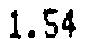

In [65]:
tdb_imgs[374]

In [66]:
refresh_main_db()

+------------------------------------------------------+-------------------------------------------------------------------------------------------------+
| Key                                                  | Value                                                                                           |
+------------------------------------------------------+-------------------------------------------------------------------------------------------------+
| d2gan_train_task12_crop50080_0002                    | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop50080_0002                    |
| d2gan_train_task12_crop_0000                         | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0000                         |
| d2gan_train_task12_crop_0001                         | /media/myungsungkwak/msdisk/docrv2_data/DB/d2gan_train_task12_crop_0001                         |
| d2gan_train_task12_crop_random_0001                  | /media/myungs

['raw_test_task12_img_txt_sample',
 'recog_train_task2_random_pad_sp_0003',
 'recog_inference_result_2497d6_raw_pad1',
 'inference_crop_0831_thr05_all_preview_detection',
 'raw_test_task12_img_txt_sample40',
 'recog_train_task2_random_pad_sp_0004',
 'd2gan_train_task12_crop50080_0002',
 'recog_train_task2_pad_sp_0003',
 'recog_train_task2_all_0001',
 'recog_train_task2_random_pad_sp_0001',
 'recog_inference_result_9ae078_raw_pad2',
 'raw_test_task12_img_txt_X51005230605',
 'raw_recog_inference_data_all_0001',
 'recog_inference_result_2497d6_raw_pad2',
 'recog_inference_result_d4637d_raw_pad7',
 'recog_train_task2_random_pad3_u80_0001',
 'recog_test_all_pad5_valid_0001',
 'recog_train_task2_random_pad3_u80_style_0002',
 'recog_inference_result_9ae078_raw_pad1',
 'raw_test_task12_img_txt_0001',
 'recog_train_task2_pad_sp_0002',
 'recog_inference_result_b15a8a_raw_pad3',
 'inference_crop_0901_thr05_sample40',
 'recog_inference_result_b15a8a_raw_pad2',
 'inference_crop_0831_thr05_sample40_